In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np

In [8]:
train_rawdata = datasets.MNIST(root = 'dataset_MNIST',
                               train = True, # True면 Train 데이터
                               download = True, # 데이터가 없으면 Download
                               transform = transforms.ToTensor()) # raw 포맷을 텐서로 바꿔줌
test_rawdata = datasets.MNIST(root = 'dataset_MNIST',
                               train = False, # False면 Test 데이터
                               download = True, # 데이터가 없으면 Download
                               transform = transforms.ToTensor()) # raw 포맷을 텐서로 바꿔줌
print('number of training data : ', len(train_rawdata))
print('number of test data : ', len(test_rawdata))

number of training data :  60000
number of test data :  10000


# Validation dataset 분리

In [9]:
VALIDATION_RATE = 0.2
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_rawdata)), # Train 데이터셋의 인덱스 번호 추출(0~59999)
    train_rawdata.targets, # y 정답 라벨
    stratify = train_rawdata.targets, # y 정답 라벨 균등분포
    test_size = VALIDATION_RATE # 여기선 Validation 데이터셋 비율
)

# torch.utils.data.Subset으로 Validation dataset 생성

In [10]:
train_dataset = Subset(train_rawdata, train_indices) # train_rawdata에 train_indices(인덱스 번호)가 추가됨
validation_dataset = Subset(train_rawdata, val_indices) # train_rawdata에 val_indices(인덱스 번호) 20%가 추가됨

In [11]:
print(len(train_dataset), len(validation_dataset), len(test_rawdata))

48000 12000 10000


# Mini-batch 생성

In [12]:
BATCH_SIZE = 128
train_batchs = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
va_batchs = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_batchs = DataLoader(test_rawdata, batch_size=BATCH_SIZE, shuffle=False)

# 시각화(참고)

In [13]:
X_train, y_train = next(iter(train_batchs))
print(X_train.shape, y_train.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [14]:
X_train[0, :, :, :].shape

torch.Size([1, 28, 28])

In [15]:
X_train[0, :, :, :].numpy().reshape(28, 28).shape

(28, 28)

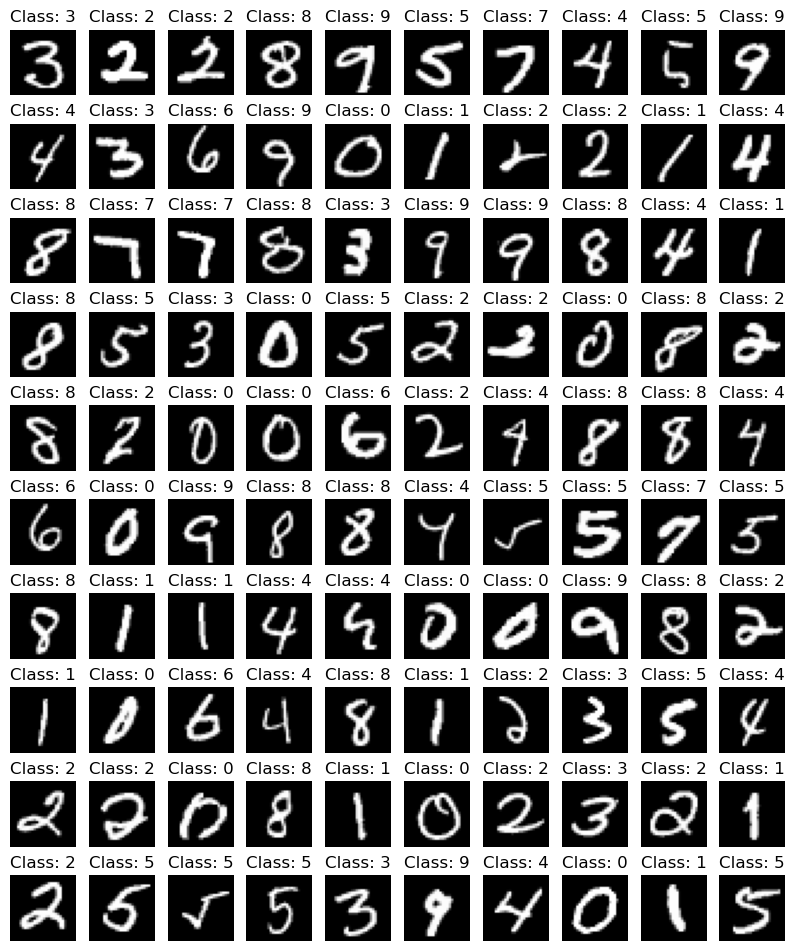

In [16]:
# 미니배치 데이터 중 100개 이미지만 출력해보기
import matplotlib.pyplot as plt
# 주피터 노트북에서 그림을 노트북 내에 표시하도록 강제하는 명령
%matplotlib inline

plt.figure(figsize=(10, 12)) # 표시할 그림의 사이즈를 정의

X_train, y_train = next(iter(train_batchs))
for index in range(100):
    plt.subplot(10, 10, index+1) # 표시할 그림들의 행렬 및 시작위치를 정의
    plt.axis('off') # 축 off
    plt.imshow(X_train[index, :, :, :].numpy().reshape(28, 28), cmap = 'gray')
    # 미니배치 X_train을 첫번째 차원(인덱스) 기준으로 ndarray로 변환시키고 그걸 다시 (28, 28)로 reshape한다, 색깔은 gray
    plt.title('Class: ' + str(y_train[index].item()))
    
plt.show()

# 모델 정의

In [17]:
X_train, y_train = next(iter(train_batchs))
print(X_train.shape, y_train.shape)
print(X_train.size(0))
print(X_train.view(X_train.size(0), -1).shape)
# 학습 데이터를 모델 입력에 맞게 변환하는 과정이 필요한데, view 함수를 써서 미니배치 [128, 1, 28, 28] 텐서를 [128, 784] 텐서(2차원)로 변환한다.

torch.Size([128, 1, 28, 28]) torch.Size([128])
128
torch.Size([128, 784])


In [18]:
class FunModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, output_dim),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        y = self.linear_layers(x)
        return y

minibatch_size = 128
input_dim = 28*28
output_dim = 10
model = FunModel(input_dim, output_dim)

loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

# 베스트 모델 저장

In [19]:
from copy import deepcopy

# Training Code 템플릿
- model : DNN 모델
- early_stop : Early Stopping을 위해, 얼마까지의 validation set에 대한 loss가 낮아지지 않을 경우 Early Stopping을 할지의 하이퍼 파라미터 값
- nb_epochs : 최대 epoch
- progress_interval : 진행상황을 얼마의 epoch마다 출력할지의 epoch 값

In [20]:
def train_model(model, early_stop, nb_epochs, progress_interval):
    train_losses, valid_losses, lowest_loss = list(), list(), np.inf

    for epoch in range(nb_epochs):
        train_loss, valid_loss = 0, 0

        # train model
        model.train() # prepare model for training
        for x_minibatch, y_minibatch in train_batchs:
            y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
            loss = loss_func(y_minibatch_pred, y_minibatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_batchs)
        train_losses.append(train_loss)

        # validate model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in va_batchs:
                y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
                loss = loss_func(y_minibatch_pred, y_minibatch)
                valid_loss += loss.item()
    
        valid_loss = valid_loss / len(va_batchs)
        valid_losses.append(valid_loss)
    
        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
        else:
            if (early_stop > 0) and lowest_epoch + early_stop < epoch:
                print("Early Stopped", epoch, "epochs")
                break
    
        if (epoch % progress_interval) == 0:
            print(train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)

    model.load_state_dict(best_model)
    return model, lowest_loss, train_losses, valid_losses

In [21]:
nb_epochs = 50
progress_interval = 10
early_stop = 5

model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

0.37650658893585204 0.1864480992105413 0.1864480992105413 0 0
0.01824912848121797 0.09733827250385459 0.08870960943440491 7 10
Early Stopped 13 epochs


In [22]:
valid_losses

[0.1864480992105413,
 0.13633949158990638,
 0.09986687039441251,
 0.10032617455804126,
 0.1032597705662409,
 0.09320817811989245,
 0.08881017841160932,
 0.08870960943440491,
 0.11507373710628599,
 0.09576356700780068,
 0.09733827250385459,
 0.12239970638357262,
 0.10931791816441778,
 0.11830035650587463]

# 테스트셋 기반 Evaluation

# 참고: 텐서 비교

In [23]:
# element-wise란?
print(torch.ne(torch.tensor([[1, 3], [2, 5]]), torch.tensor([[1, 2], [2, 3]])))
print(torch.equal(torch.tensor([[1, 3], [2, 5]]), torch.tensor([[1, 2], [2, 3]])))

tensor([[False,  True],
        [False,  True]])
False


In [32]:
x_minibatch, y_minibatch = next(iter(test_batchs))
y_test_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
pred = torch.argmax(y_test_pred, dim=1)
print(y_test_pred.shape, y_minibatch.shape, pred.shape)
correct = pred.eq(y_minibatch).sum()
print(pred.eq(y_minibatch).sum(), pred.eq(y_minibatch).sum().item())

torch.Size([128, 10]) torch.Size([128]) torch.Size([128])
tensor(127) 127


# 참고: 텐서객체.nonzero()

In [33]:
torch.tensor([[0.6, 0.0, 0.0, 0.0],
              [0.0, 0.4, 1.0, 0.0],
              [0.0, 0.0, 1.2, 0.0],
              [0.0, 0.0, 0.0, -0.4]]).nonzero()

tensor([[0, 0],
        [1, 1],
        [1, 2],
        [2, 2],
        [3, 3]])

# 참고: 슬라이싱

In [34]:
data = torch.FloatTensor([[1, 2], [3, 4]])
print(data.shape, data[:, 0])

torch.Size([2, 2]) tensor([1., 3.])


# len(test_batchs.dataset) : 전체 데이터셋 길이

In [35]:
len(test_batchs.dataset)

10000

# 비교 코드

In [37]:
# 테스트셋에서 틀린 예측이 있는 인덱스를 리스트로 만드는 과정
print(pred.ne(y_minibatch).shape, pred.ne(y_minibatch), pred.ne(y_minibatch).nonzero(), pred.ne(y_minibatch).nonzero()[:, 0], pred.ne(y_minibatch).nonzero()[:, 0].numpy().tolist())

torch.Size([128]) tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, Fal

In [40]:
wrong_idx = pred.ne(y_minibatch).nonzero()[:, 0].numpy().tolist()
for index in wrong_idx:
    print(index)

38


# 최종 코드

In [41]:
test_loss = 0
correct = 0
wrong_samples, wrong_preds, actual_preds = list(), list(), list()

model.eval()
with torch.no_grad():
    for x_minibatch, y_minibatch in test_batchs:
        y_test_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
        test_loss += loss_func(y_test_pred, y_minibatch)
        pred = torch.argmax(y_test_pred, dim=1)
        correct += pred.eq(y_minibatch).sum().item()

        wrong_idx = pred.ne(y_minibatch).nonzero()[:, 0].numpy().tolist()
        for index in wrong_idx:
            wrong_samples.append(x_minibatch[index])
            wrong_preds.append(pred[index])
            actual_preds.append(y_minibatch[index])

test_loss /= len(test_batchs.dataset)
print('Average Test Loss: {:.4f}'.format(test_loss))
print('Accuracy: {}/{} ({:.2f}%)'.format(correct, len(test_batchs.dataset), 100*correct/len(test_batchs.dataset)))

Average Test Loss: 0.0006
Accuracy: 9764/10000 (97.64%)


# incorrect data만 확인해보기

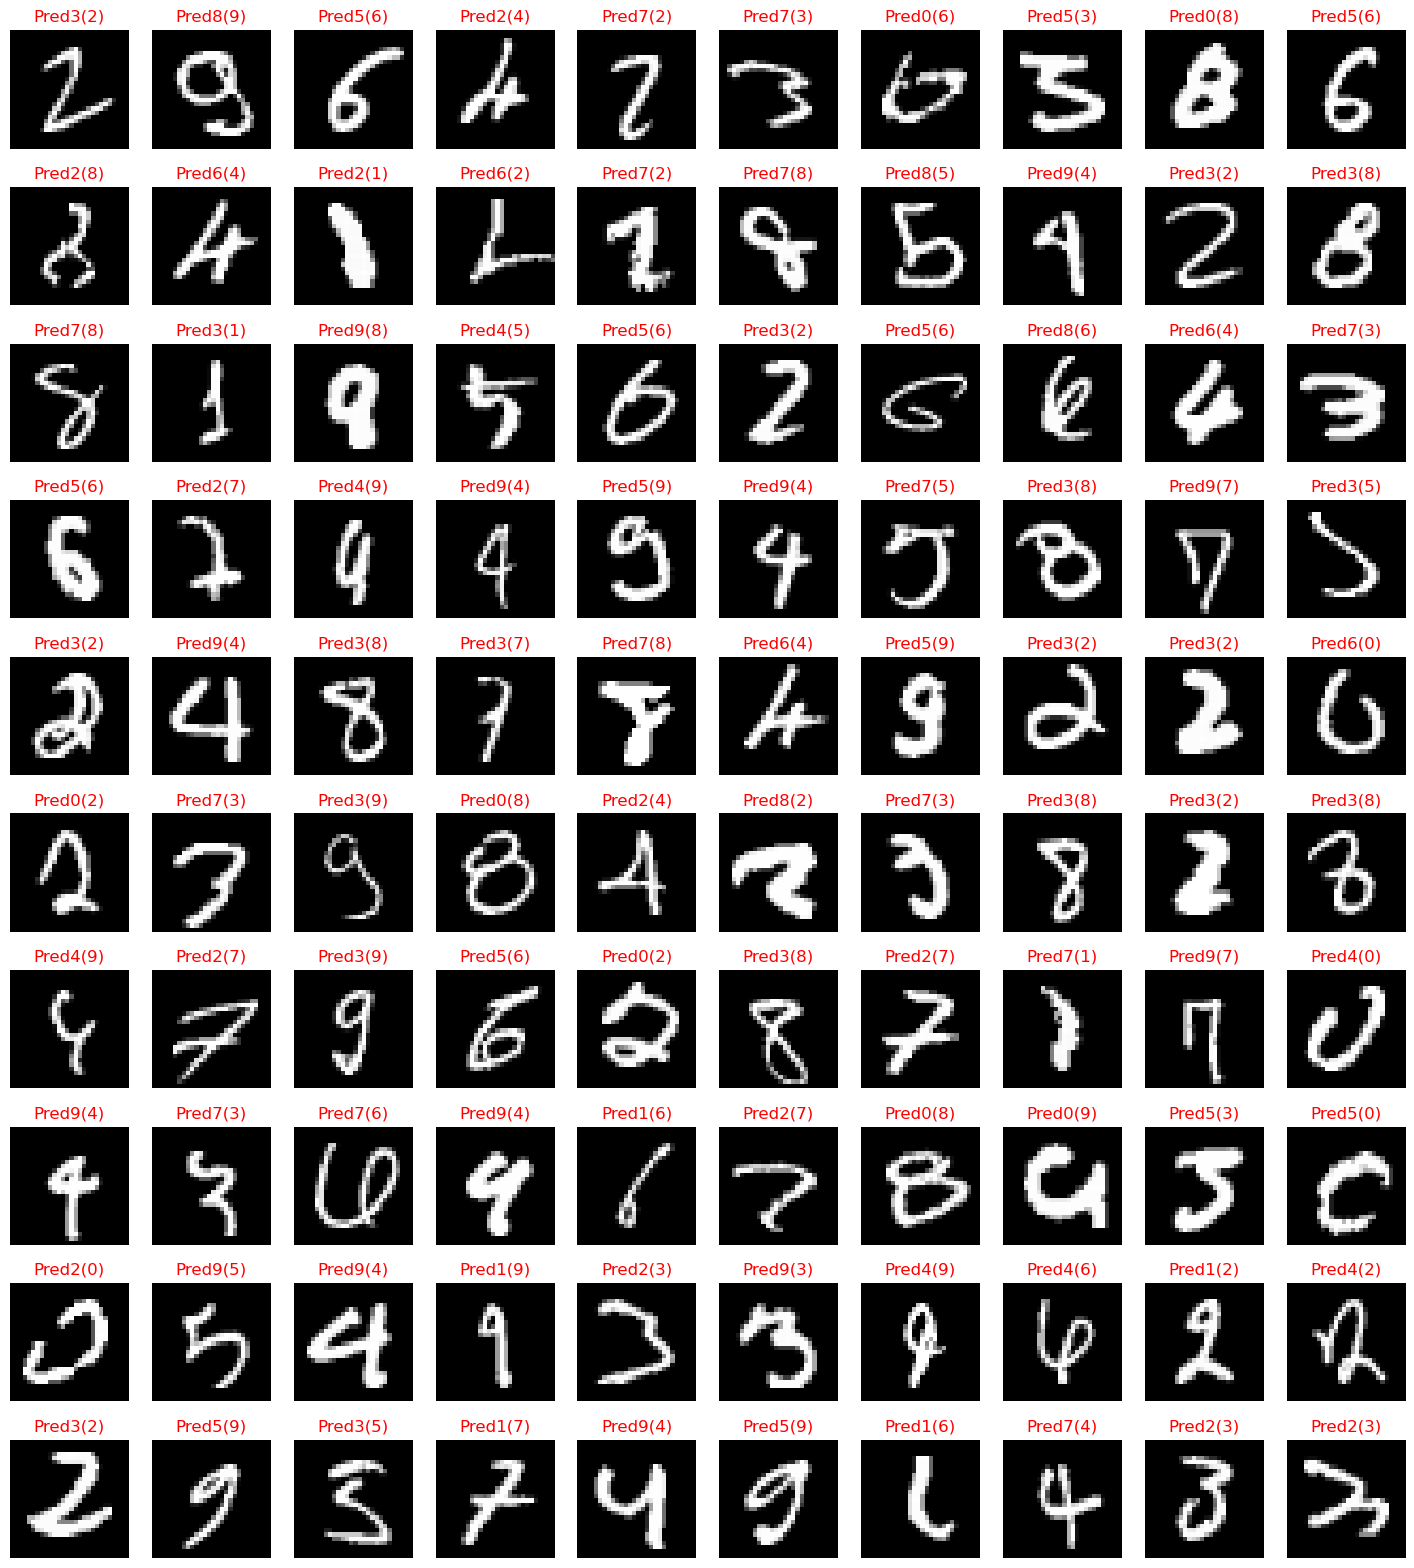

In [62]:
plt.figure(figsize=(18, 20))

for index in range(100):
    plt.subplot(10, 10, index+1)
    plt.axis('off')
    plt.imshow(wrong_samples[index].numpy().reshape(28, 28), cmap='gray')
    plt.title("Pred" + str(wrong_preds[index].item()) + "(" + str(actual_preds[index].item()) + ")", color='red')
    
plt.show()